# T360761 Empty Wikidata Values

Task: [T360761](https://phabricator.wikimedia.org/T360761)

### Goals

- How often is an empty item made and either filled in later or never filled in at all?

### Steps

- [x] Exploration of [wmf.mediawiki_history](https://wikitech.wikimedia.org/wiki/Analytics/Data_Lake/Edits/MediaWiki_history) and [wmf.mediawiki_history_reduced](https://wikitech.wikimedia.org/wiki/Analytics/Data_Lake/Edits/Mediawiki_history_reduced)
  - Columns needed:
    - Project/wiki_db (both)
    - page_id (both)
    - event_type (both)
    - page_is_deleted (only `mediawiki_history`)
  - From the above, we need to use `mediawiki_history`
- [x] Population A
  - All Wikidata Items (including deleted Items, and independent of source, e.g. including UI and Action API edits)
  - [x] Task 1.1: Number of Items in Population A that were created empty
  - [x] Task 1.2: Number of editors who are creating empty items
- [x] Population B
  - Items in Population A that were created empty (results of Task 1)
  - [x] Task 2: Number of Items in Population B that are currently deleted
- [x] Population C
  - Items in Population B that are currently not deleted (results of Task 1 that are the complement of the results of Task 2)
  - [x] Number of Items in Population C with...
    - [x] Task 3.1: no further edits ever
    - [x] Task 3.2: at least one additional edit (=the rest)
    - [x] Task 3.3: graphs of the number of edits the items have had

## Imports and Session

In [1]:
%load_ext jupyter_black

In [56]:
import sys

sys.path.append("../../../")  # for accessing analytics_utils.py
from analytics_utils import display_peek, get_plot_axis_png_title, print_spark_session_info

import requests

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import wmfdata as wmf

In [ ]:
pd.set_option("display.max_rows", 16)
pd.set_option("display.max_columns", None)

sns.set(style="darkgrid")
sns.set(rc={"figure.figsize": (15, 5)})

In [3]:
spark = wmf.spark.create_session(type="yarn-large", app_name="empty_wikidata_items")

In [4]:
print_spark_session_info(spark=spark)

Spark version: 3.1.2
Spark app name: empty-wikidata-items
Scheduler UI: https://yarn.wikimedia.org/proxy/application_1713453355160_36685


## Exploration

### Snapshot to Query

In [5]:
max_snapshot_query = """
SELECT
    max(snapshot) AS max_snapshot

FROM
    wmf.mediawiki_history

WHERE
    wiki_db = 'wikidatawiki'
;
"""

In [6]:
# df_snapshot_to_query = spark.sql(max_snapshot_query).collect()
# df_snapshot_to_query[0]["max_snapshot"]

In [7]:
snapshot_to_query = "2024-03"

### Table Head

In [8]:
explore_mediawiki_history_query = f"""
SELECT
    *

FROM
    wmf.mediawiki_history

WHERE
    wiki_db = 'wikidatawiki'
    AND snapshot = '{snapshot_to_query}'

LIMIT
    5
;
"""

In [9]:
df_explore_mediawiki_history = spark.sql(explore_mediawiki_history_query).toPandas()

In [10]:
display_peek(df_explore_mediawiki_history)


Display of DataFrame cleared.



Columns to consider:
- `event_entity`: we're looking at `'page'` for item creation and `'revision'` for edits (Tasks 3.x)
- `event_type`: we want `'create'`
- `event_timestamp`: for comparing if there was a coinciding revision with page creation
- `page_namespace_is_content`: include to make sure we're looking at items 
- `page_is_deleted`: the means for deriving Task 2 and Population C
- `page_revision_count`: investigate the status and values of this
  - There are no `page_revision_count = 0` entries
  - What do items that are created empty have for this when they've not been edited?
    - NaN for the creation, but then there will be a coinciding revision that comes after
- `page_seconds_since_previous_revision`: NaN indicates the first revision
- `revision_parent_id`: 0 indicates the first revision
- `revision_is_from_before_page_creation`: we don't want these included in the counts as ones with edits, but then again they wouldn't be empty (monitor)

### Types of Events

In [11]:
event_types_query = f"""
SELECT DISTINCT
    event_type AS event_types

FROM
    wmf.mediawiki_history

WHERE
    wiki_db = 'wikidatawiki'
    AND page_namespace_is_content = True
    AND snapshot = '{snapshot_to_query}'
;
"""

In [12]:
# df_event_types = spark.sql(event_types_query)

In [13]:
# df_event_types.show()

```
+-----------+
|event_types|
+-----------+
|     rename|
|     create|
|      merge|
|    restore|
|     delete|
|       move|
|alterblocks|
|altergroups|
+-----------+
```

### Revision Count

In [14]:
no_revision_count_exploration_query = f"""
SELECT
    *

FROM
    wmf.mediawiki_history

WHERE
    wiki_db = 'wikidatawiki'
    AND page_namespace_is_content = True
    AND snapshot = '{snapshot_to_query}'
    AND page_revision_count = 0

LIMIT
    5
;
"""

In [15]:
# df_no_revision_count_exploration = spark.sql(
#     no_revision_count_exploration_query
# ).toPandas()

In [16]:
# display_peek(df_no_revision_count_exploration)

There are no `page_revision_count = 0` entries.

In [17]:
create_page_exploration_query = f"""
SELECT
    *

FROM
    wmf.mediawiki_history

WHERE
    wiki_db = 'wikidatawiki'
    AND page_namespace_is_content = True
    AND snapshot = '{snapshot_to_query}'
    AND event_entity = 'page'
    AND event_type = 'create'

LIMIT
    5
;
"""

In [18]:
# df_create_page_exploration = spark.sql(create_page_exploration_query).toPandas()

In [19]:
# display_peek(df_create_page_exploration)

Observations:

- `page_revision_count = NaN`
- `revision_parent_id = NaN`

Ultimately we need to look into first revisions as there will always be one present for each item creation.

### Deriving Empty Item Creations

As of now it's impossible to know if there was or was not content in the revision that inherently is triggered by the creation of an item. There was originally a dump of the historical text of Wikidata, but this was removed as there was no use case and the size/wait time for it was massive.

The one way to do this would be to find out what the byte size of an empty revision is. A first attempt is assuming that the minimum byte size for a revision would be one that is empty. We'll need to check:

- revision_text_bytes (size of revision)
- revision_text_bytes_diff (change in bytes relative to parent - can be negative)

Maybe those revisions that have a revision `event_timestamp` that's the same as the creation `event_timestamp` and a `revision_text_bytes` equal to the minimum for this value?

#### Minimum Byte Sizes

In [20]:
min_revision_text_bytes_query = """
SELECT
    min(revision_text_bytes) AS min_revision_text_bytes

FROM
    wmf.mediawiki_history

WHERE
    wiki_db = 'wikidatawiki'
    AND page_namespace_is_content = True
    AND snapshot = '{snapshot_to_query}'
    AND event_entity = 'revision'
    AND event_type = 'create'
;
"""

In [21]:
# df_min_revision_text_bytes = spark.sql(min_revision_text_bytes_query).collect()
# df_min_revision_text_bytes[0]["min_revision_text_bytes"]

`min_revision_text_bytes` is `None`.

In [22]:
min_revision_text_bytes_diff_query = f"""
SELECT
    min(revision_text_bytes_diff) AS min_revision_text_bytes_diff

FROM
    wmf.mediawiki_history

WHERE
    wiki_db = 'wikidatawiki'
    AND page_namespace_is_content = True
    AND snapshot = '{snapshot_to_query}'
    AND event_entity = 'revision'
    AND event_type = 'create'
;
"""

In [23]:
# df_min_revision_text_bytes_diff = spark.sql(
#     min_revision_text_bytes_diff_query
# ).collect()
# df_min_revision_text_bytes_diff[0]["min_revision_text_bytes_diff"]

`min_revision_text_bytes_diff` is `None`.

#### Revisions with Minimum Byte Size

In [24]:
minimum_byte_size_exploration_query = f"""
SELECT
    *

FROM
    wmf.mediawiki_history

WHERE
    wiki_db = 'wikidatawiki'
    AND page_namespace_is_content = True
    AND snapshot = '{snapshot_to_query}'
    AND event_entity = 'revision'
    AND event_type = 'create'
    AND revision_text_bytes IS NULL

LIMIT
    5
;
"""

In [25]:
# df_minimum_byte_size_exploration = spark.sql(
#     minimum_byte_size_exploration_query
# ).toPandas()

In [26]:
# display_peek(df_minimum_byte_size_exploration)

Various revisions, but they don't appear to be item creation revisions as the items have prior revisions and other data.

#### Deleted Items with Non-null Byte Revisions

In [27]:
deleted_item_with_non_null_byte_size_exploration_query = f"""
SELECT
    *

FROM
    wmf.mediawiki_history

WHERE
    wiki_db = 'wikidatawiki'
    AND page_namespace_is_content = True
    AND snapshot = '{snapshot_to_query}'
    AND event_entity = 'revision'
    AND event_type = 'create'
    AND page_is_deleted = True
    AND revision_text_bytes IS NOT NULL

LIMIT
    5
;
"""

In [28]:
# df_deleted_item_with_non_null_byte_size_exploration_query = spark.sql(
#     deleted_item_with_non_null_byte_size_exploration_query
# ).toPandas()

In [29]:
# display_peek(df_deleted_item_with_non_null_byte_size_exploration_query)

There are entries, so `NULL` is not being set for revision bytes for deleted items.

#### Checking Low Byte Revisions

An example provided for this is [Beta Q628257](https://wikidata.beta.wmflabs.org/w/index.php?title=Q628257&oldid=1357018), with the bytes of the sole empty revision being `157`. If we take this as a baseline value, the question then arises of are there any content edits that are less than this amount of bytes? If not, then we can use this as a cutoff, but if so we'd need to figure out a way to distinguish them or progressing may prove too difficult. Note also that `157` also includes bytes for the QID, so longer QIDs will inherently be more bytes.

In [30]:
# low_byte_revision_cutoff = 157

Original `WHERE` clause:

```sql
WHERE
    wiki_db = 'wikidatawiki'
    AND page_namespace_is_content = True
    AND snapshot = '{snapshot_to_query}'
    AND event_entity = 'revision'
    AND event_type = 'create'
    AND revision_text_bytes < {low_byte_revision_cutoff}
```


In [31]:
low_byte_revision_exploration_query = f"""
SELECT
    *

FROM
    wmf.mediawiki_history

WHERE
    wiki_db = 'wikidatawiki'
    AND page_namespace_is_content = True
    AND snapshot = '{snapshot_to_query}'
    AND event_entity = 'revision'
    AND event_type = 'create'
    AND page_revision_count = 1
    -- Factor in bytes allocated to a first revision given the size of a QID.
    AND revision_text_bytes = CASE
        WHEN LENGTH(page_title) = 2 THEN 148
        WHEN LENGTH(page_title) = 3 THEN 149
        WHEN LENGTH(page_title) = 4 THEN 150
        WHEN LENGTH(page_title) = 5 THEN 151
        WHEN LENGTH(page_title) = 6 THEN 152
        WHEN LENGTH(page_title) = 7 THEN 153
        WHEN LENGTH(page_title) = 8 THEN 154
        WHEN LENGTH(page_title) = 9 THEN 155
        WHEN LENGTH(page_title) = 10 THEN 156
    END

LIMIT
    1000
;
"""

In [32]:
# df_low_byte_revision_exploration = spark.sql(
#     low_byte_revision_exploration_query
# ).toPandas()

In [33]:
# display_peek(df_low_byte_revision_exploration, rows=1000)

Observations:
- 65 byte edit that redirected Q16252779 to Q3840531
  - All of them have `page_is_redirect = True`
  - Is `page_is_redirect = False` needed with the bytes-QID check?
    - No
- Trying to add `page_is_redirect = False`
  - One 65 byte entry that's `revision_is_identity_reverted = False`
  - Is `revision_is_identity_reverted = True` needed with the bytes-QID check?
    - No
- Trying to subset between 148 and 156 bytes
  - 8-digit QIDs (not including the Q) that have an empty first revision have `155` byte revisions
  - We need to subset it for the exact bytes per digit
  
Other conditions to factor in:
- Include `page_revision_count = 1` to make sure it's the first revision

## Results

### Population A

**Description**

All Wikidata Items (including deleted Items, and independent of source, e.g. including UI and Action API edits).

#### V1 Population Definition

In [42]:
created_empty_qids_query = f"""
SELECT DISTINCT
    event_user_text AS editor,
    substring(event_timestamp, 1, 7) AS event_year_month,
    page_title AS created_empty_qid

FROM
    wmf.mediawiki_history

WHERE
    wiki_db = 'wikidatawiki'
    AND page_namespace_is_content = True
    AND snapshot = '{snapshot_to_query}'
    AND event_entity = 'revision'
    AND event_type = 'create'
    AND page_revision_count = 1
    -- Factor in bytes allocated to a first revision given the size of a QID.
    AND revision_text_bytes = CASE
        WHEN LENGTH(page_title) = 2 THEN 148
        WHEN LENGTH(page_title) = 3 THEN 149
        WHEN LENGTH(page_title) = 4 THEN 150
        WHEN LENGTH(page_title) = 5 THEN 151
        WHEN LENGTH(page_title) = 6 THEN 152
        WHEN LENGTH(page_title) = 7 THEN 153
        WHEN LENGTH(page_title) = 8 THEN 154
        WHEN LENGTH(page_title) = 9 THEN 155
        WHEN LENGTH(page_title) = 10 THEN 156
    END
"""

In [43]:
df_created_empty_qids = spark.sql(created_empty_qids_query).cache()
df_created_empty_qids.createOrReplaceTempView("df_created_empty_qids")

#### Task 1.1: Number Created Empty

In [48]:
total_created_empty_qids_query = """
SELECT
    count(DISTINCT created_empty_qid) AS total_created_empty_qids

FROM
    df_created_empty_qids
"""

In [49]:
df_total_created_empty_qids = spark.sql(total_created_empty_qids_query)

In [50]:
df_total_created_empty_qids.show()

+------------------------+
|total_created_empty_qids|
+------------------------+
|                  760318|
+------------------------+



#### Task 1.2: Editors Creating Empty Items

In [51]:
total_editors_creating_empty_qids_query = """
SELECT
    count(DISTINCT editor) AS total_editors_creating_empty_qids

FROM
    df_created_empty_qids
"""

In [52]:
df_total_editors_creating_empty_qids = spark.sql(
    total_editors_creating_empty_qids_query
)

In [53]:
df_total_editors_creating_empty_qids.show()

+---------------------------------+
|total_editors_creating_empty_qids|
+---------------------------------+
|                              146|
+---------------------------------+



#### V2 Population Definition

Given the check of dates below, it appears as if the size of empty items has changed over time. The following query reflective of the size of the first empty edit of [Beta Q628257](https://wikidata.beta.wmflabs.org/wiki/Q628257).

##### Exploration

In [108]:
created_empty_qids_v2_exploration_query = f"""
SELECT
    *

FROM
    wmf.mediawiki_history

WHERE
    wiki_db = 'wikidatawiki'
    AND page_namespace_is_content = True
    AND snapshot = '{snapshot_to_query}'
    AND event_entity = 'revision'
    AND event_type = 'create'
    AND page_revision_count = 1
    -- Factor in bytes allocated to a first revision given the size of a QID.
    AND revision_text_bytes = CASE
        WHEN LENGTH(page_title) = 2 THEN 152
        WHEN LENGTH(page_title) = 3 THEN 153
        WHEN LENGTH(page_title) = 4 THEN 154
        WHEN LENGTH(page_title) = 5 THEN 155
        WHEN LENGTH(page_title) = 6 THEN 156
        WHEN LENGTH(page_title) = 7 THEN 157
        WHEN LENGTH(page_title) = 8 THEN 158
        WHEN LENGTH(page_title) = 9 THEN 159
        WHEN LENGTH(page_title) = 10 THEN 160
    END

LIMIT
    1000
;
"""

In [109]:
df_created_empty_qids_v2_exploration = spark.sql(
    created_empty_qids_v2_exploration_query
).toPandas()

In [110]:
display_peek(df_created_empty_qids_v2_exploration, rows=1000)


Display of DataFrame cleared.



##### New Query

In [38]:
created_empty_qids_v2_query = f"""
SELECT DISTINCT
    event_user_text AS editor,
    substring(event_timestamp, 1, 7) AS event_year_month,
    page_title AS created_empty_qid

FROM
    wmf.mediawiki_history

WHERE
    wiki_db = 'wikidatawiki'
    AND page_namespace_is_content = True
    AND snapshot = '{snapshot_to_query}'
    AND event_entity = 'revision'
    AND event_type = 'create'
    AND page_revision_count = 1
    -- Factor in bytes allocated to a first revision given the size of a QID.
    AND revision_text_bytes = CASE
        WHEN LENGTH(page_title) = 2 THEN 152
        WHEN LENGTH(page_title) = 3 THEN 153
        WHEN LENGTH(page_title) = 4 THEN 154
        WHEN LENGTH(page_title) = 5 THEN 155
        WHEN LENGTH(page_title) = 6 THEN 156
        WHEN LENGTH(page_title) = 7 THEN 157
        WHEN LENGTH(page_title) = 8 THEN 158
        WHEN LENGTH(page_title) = 9 THEN 159
        WHEN LENGTH(page_title) = 10 THEN 160
    END
;
"""

In [39]:
df_created_empty_qids_v2 = spark.sql(created_empty_qids_v2_query).cache()
df_created_empty_qids_v2.createOrReplaceTempView("df_created_empty_qids_v2")

#### Task 1.1 V2: Number Created Empty

In [97]:
total_created_empty_qids_v2_query = """
SELECT
    count(DISTINCT created_empty_qid) AS total_created_empty_qids

FROM
    df_created_empty_qids_v2
"""

In [98]:
df_total_created_empty_qids_v2 = spark.sql(total_created_empty_qids_v2_query)

In [99]:
df_total_created_empty_qids_v2.show()

+------------------------+
|total_created_empty_qids|
+------------------------+
|                 3540260|
+------------------------+



#### Task 1.2 V2: Editors Creating Empty Items

In [103]:
total_editors_creating_empty_qids_v2_query = """
SELECT
    count(DISTINCT editor) AS total_editors_creating_empty_qids

FROM
    df_created_empty_qids_v2
"""

In [104]:
df_total_editors_creating_empty_qids_v2 = spark.sql(
    total_editors_creating_empty_qids_v2_query
)

In [105]:
df_total_editors_creating_empty_qids_v2.show()

+---------------------------------+
|total_editors_creating_empty_qids|
+---------------------------------+
|                             1157|
+---------------------------------+



#### V3 Population Definition

With the V2 population we were not getting revisions later than 2020. The expectation is that with bots like QuickStatementsBot and others like making empty items, that this practice would almost certainly being continuing today. We'll now use a range for the byte sizes of empty first revisions, which will inherently get us revisions that are not empty. We can specifically check samples of the new samples for edits after 2020 to then see if empty items are still being made.

##### Exploration

In [34]:
created_empty_qids_v3_exploration_query = f"""
SELECT
    *

FROM
    wmf.mediawiki_history

WHERE
    wiki_db = 'wikidatawiki'
    AND page_namespace_is_content = True
    AND snapshot = '{snapshot_to_query}'
    AND event_entity = 'revision'
    AND event_type = 'create'
    AND page_revision_count = 1
    -- Factor in bytes that are within a range small enough to be an empty first edit.
    AND 148 < revision_text_bytes
    AND revision_text_bytes < 170

LIMIT
    1000
;
"""

In [35]:
df_created_empty_qids_v3_exploration = spark.sql(
    created_empty_qids_v3_exploration_query
).toPandas()

In [36]:
display_peek(df_created_empty_qids_v3_exploration, rows=1000)


Display of DataFrame cleared.



##### New Query

In [112]:
created_empty_qids_v3_query = f"""
SELECT DISTINCT
    event_user_text AS editor,
    substring(event_timestamp, 1, 7) AS event_year_month,
    page_title AS created_empty_qid

FROM
    wmf.mediawiki_history

WHERE
    wiki_db = 'wikidatawiki'
    AND page_namespace_is_content = True
    AND snapshot = '{snapshot_to_query}'
    AND event_entity = 'revision'
    AND event_type = 'create'
    AND page_revision_count = 1
    -- Factor in bytes that are within a range small enough to be an empty first edit.
    AND 148 < revision_text_bytes
    AND revision_text_bytes < 170
;
"""

In [113]:
df_created_empty_qids_v3 = spark.sql(created_empty_qids_v3_query).cache()
df_created_empty_qids_v3.createOrReplaceTempView("df_created_empty_qids_v3")

#### Task 1.1 V3: Number Created Empty

In [39]:
total_created_empty_qids_v3_query = """
SELECT
    count(DISTINCT created_empty_qid) AS total_created_empty_qids

FROM
    df_created_empty_qids_v3
"""

In [40]:
df_total_created_empty_qids_v3 = spark.sql(total_created_empty_qids_v3_query)

In [41]:
df_total_created_empty_qids_v3.show()

+------------------------+
|total_created_empty_qids|
+------------------------+
|                 5075471|
+------------------------+



#### Task 1.2 V3: Editors Creating Empty Items

In [42]:
total_editors_creating_empty_qids_v3_query = """
SELECT
    count(DISTINCT editor) AS total_editors_creating_empty_qids

FROM
    df_created_empty_qids_v3
"""

In [43]:
df_total_editors_creating_empty_qids_v3 = spark.sql(
    total_editors_creating_empty_qids_v3_query
)

In [44]:
df_total_editors_creating_empty_qids_v3.show()

+---------------------------------+
|total_editors_creating_empty_qids|
+---------------------------------+
|                             2761|
+---------------------------------+



### Method Checks

#### Random Sample

##### V2 Sample of 1,000

The method devised above definitely needs to be checked as byte sizes of revisions being maintained over time can't be assumed. A check of this will be to sample 1,000 of the QIDs derived in `Task 1` and actually bring down their first revision programmatically with an API to check that it's empty. If they all are empty, then the methodology will be supported.

In [42]:
sample_1000_potentially_created_empty_items_query = f"""
WITH created_empty_qid_revisions AS (
    SELECT
        h.page_title AS created_empty_qid,
        min(h.revision_id) AS first_revision_id

    FROM
        wmf.mediawiki_history AS h

    JOIN
        df_created_empty_qids_v2 AS e

    ON
        h.page_title = e.created_empty_qid

    WHERE
        h.wiki_db = 'wikidatawiki'
        AND h.page_namespace_is_content = True
        AND h.snapshot = '{snapshot_to_query}'
        AND h.event_entity = 'revision'
        AND h.event_type = 'create'

    GROUP BY
        h.page_title
),

random_order_of_created_empty_qids AS (
    SELECT
        created_empty_qid AS created_empty_qid,
        first_revision_id AS first_revision_id,
        rand() AS random

    FROM
        created_empty_qid_revisions

    ORDER BY
        random
)

SELECT
    created_empty_qid AS created_empty_qid,
    first_revision_id AS first_revision_id

FROM
    random_order_of_created_empty_qids

LIMIT
    1000
"""

In [43]:
df_sample_1000_potentially_created_empty_items = spark.sql(
    sample_1000_potentially_created_empty_items_query
).toPandas()

In [44]:
len(df_sample_1000_potentially_created_empty_items)

1000

In [45]:
display_peek(df_sample_1000_potentially_created_empty_items)


Display of DataFrame cleared.



In [58]:
actually_empty_qids_v2 = 0
actually_not_empty_qids_v2 = 0

for i in tqdm(
    df_sample_1000_potentially_created_empty_items.index,
    desc="QIDs checked",
    unit="qids",
):
    qid = df_sample_1000_potentially_created_empty_items["created_empty_qid"][i]
    rev_id = df_sample_1000_potentially_created_empty_items["first_revision_id"][i]

    try:
        r = requests.get(
            f"https://www.wikidata.org/wiki/Special:EntityData/{qid}.json?revision={rev_id}"
        )
        data = r.json()
        entities = data["entities"][qid]

        if entities["labels"]:
            actually_not_empty_qids_v2 += 1

        elif entities["descriptions"]:
            actually_not_empty_qids_v2 += 1

        elif entities["aliases"]:
            actually_not_empty_qids_v2 += 1

        elif entities["claims"]:
            actually_not_empty_qids_v2 += 1

        elif entities["sitelinks"]:
            actually_not_empty_qids_v2 += 1

        else:
            actually_empty_qids_v2 += 1

    except:
        pass

QIDs checked: 100%|██████████| 1000/1000 [00:22<00:00, 45.21qids/s]


In [59]:
total_checked_v2 = actually_empty_qids_v2 + actually_not_empty_qids_v2
percent_actually_created_empty_v2 = round(
    actually_empty_qids_v2 / (total_checked_v2) * 100, 2
)

print(
    f"Percent of {total_checked_v2:,} random created empty items that are actually empty on first revision: {percent_actually_created_empty_v2}"
)

Percent of 991 random created empty items that are actually empty on first revision: 100.0


##### V3 Sample of 50,000

In a similar way to the check of V2 above, we'll bring down a random sample of the revisions and check that they're actually empty. We'll do a larger sample of 50,000 now, or 1% of the potentially empty revisions.

In [60]:
sample_50000_potentially_created_empty_items_query = f"""
WITH created_empty_qid_revisions AS (
    SELECT
        h.page_title AS created_empty_qid,
        min(h.revision_id) AS first_revision_id

    FROM
        wmf.mediawiki_history AS h

    JOIN
        df_created_empty_qids_v3 AS e

    ON
        h.page_title = e.created_empty_qid

    WHERE
        h.wiki_db = 'wikidatawiki'
        AND h.page_namespace_is_content = True
        AND h.snapshot = '{snapshot_to_query}'
        AND h.event_entity = 'revision'
        AND h.event_type = 'create'

    GROUP BY
        h.page_title
),

random_order_of_created_empty_qids AS (
    SELECT
        created_empty_qid AS created_empty_qid,
        first_revision_id AS first_revision_id,
        rand() AS random

    FROM
        created_empty_qid_revisions

    ORDER BY
        random
)

SELECT
    created_empty_qid AS created_empty_qid,
    first_revision_id AS first_revision_id

FROM
    random_order_of_created_empty_qids

LIMIT
    50000
"""

In [61]:
df_sample_50000_potentially_created_empty_items = spark.sql(
    sample_50000_potentially_created_empty_items_query
).toPandas()

In [62]:
len(df_sample_50000_potentially_created_empty_items)

50000

In [63]:
display_peek(df_sample_50000_potentially_created_empty_items)


Display of DataFrame cleared.



In [64]:
actually_empty_qids_v3 = 0
actually_not_empty_qids_v3 = 0

for i in tqdm(
    df_sample_50000_potentially_created_empty_items.index,
    desc="QIDs checked",
    unit="qids",
):
    qid = df_sample_50000_potentially_created_empty_items["created_empty_qid"][i]
    rev_id = df_sample_50000_potentially_created_empty_items["first_revision_id"][i]

    try:
        r = requests.get(
            f"https://www.wikidata.org/wiki/Special:EntityData/{qid}.json?revision={rev_id}"
        )
        data = r.json()
        entities = data["entities"][qid]

        if entities["labels"]:
            actually_not_empty_qids_v3 += 1

        elif entities["descriptions"]:
            actually_not_empty_qids_v3 += 1

        elif entities["aliases"]:
            actually_not_empty_qids_v3 += 1

        elif entities["claims"]:
            actually_not_empty_qids_v3 += 1

        elif entities["sitelinks"]:
            actually_not_empty_qids_v3 += 1

        else:
            actually_empty_qids_v3 += 1

    except:
        pass

QIDs checked: 100%|██████████| 50000/50000 [1:36:43<00:00,  8.62qids/s]  


In [65]:
total_checked_v3 = actually_empty_qids_v3 + actually_not_empty_qids_v3
percent_actually_created_empty_v3 = round(
    actually_empty_qids_v3 / (total_checked_v3) * 100, 2
)

print(
    f"Percent of {total_checked_v3:,} random created empty items that are actually empty on first revision: {percent_actually_created_empty_v3}"
)

Percent of 49,579 random created empty items that are actually empty on first revision: 99.65


#### Empty Revisions Over Time

Another check would be to make sure that the `event_timestamp` for empty item creations is generally distributed over time such that we're getting spans over a longer period than just the 2013/2014 revisions returned in the initial exploration. This is important so that don't make an assumption based on data modeling for byte allocation that might not be consistent over time.

##### V1 Population Definition

In [56]:
empty_qids_per_month_query = """
SELECT
    event_year_month AS event_year_month,
    count(event_year_month) AS total_empty_qid_creations

FROM
    df_created_empty_qids

GROUP BY
    event_year_month

ORDER BY
    event_year_month ASC
"""

In [57]:
df_empty_qids_per_month = spark.sql(empty_qids_per_month_query).toPandas()

In [73]:
display_peek(df_empty_qids_per_month)


Display of DataFrame cleared.



In [79]:
# We don't have any data for 2014-03 as there were no created empty items made, so adding 0 for the plot.
if "2014-03" not in df_empty_qids_per_month["event_year_month"].values:
    data_to_add = {"event_year_month": ["2014-03"], "total_empty_qid_creations": [0]}
    row_to_add = pd.DataFrame(data_to_add)

    df_empty_qids_per_month = pd.concat(
        [df_empty_qids_per_month, row_to_add], ignore_index=True
    )
    df_empty_qids_per_month = df_empty_qids_per_month.sort_values(
        "event_year_month", ascending=True
    )
    df_empty_qids_per_month.reset_index(drop=True, inplace=True)

In [181]:
max(df_empty_qids_per_month["event_year_month"])

'2014-08'

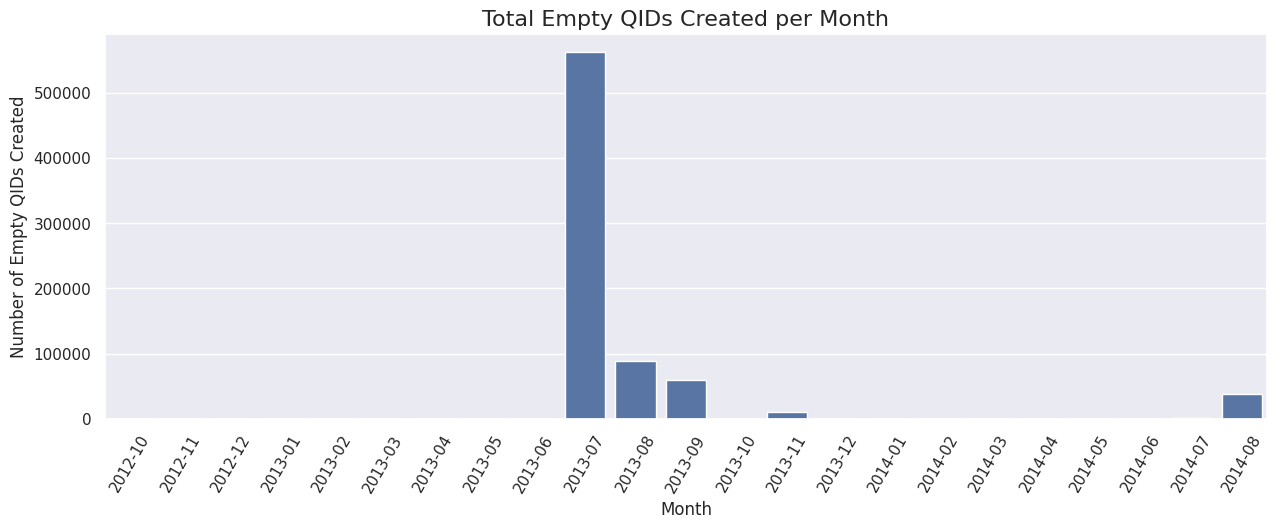

In [177]:
ax = sns.barplot(
    data=df_empty_qids_per_month,
    x="event_year_month",
    y="total_empty_qid_creations",
)
ax.set_title(
    "Total Empty QIDs Created per Month",
    size=16,
)
ax.set(xlabel="Month", ylabel="Number of Empty QIDs Created")
ax.tick_params(axis="x", rotation=60)
plt.savefig(get_plot_axis_png_title(ax=ax, directory="visual_outputs"), bbox_inches="tight")
plt.show()

##### V2 Population Definition

In [111]:
empty_qids_per_month_v2_query = """
SELECT
    event_year_month AS event_year_month,
    count(event_year_month) AS total_empty_qid_creations

FROM
    df_created_empty_qids_v2

GROUP BY
    event_year_month

ORDER BY
    event_year_month ASC
"""

In [112]:
df_empty_qids_per_month_v2 = spark.sql(empty_qids_per_month_v2_query).toPandas()

In [113]:
display_peek(df_empty_qids_per_month_v2)


Display of DataFrame cleared.



In [179]:
# We don't have data for some months as there were no created empty items made during them.

In [180]:
max(df_empty_qids_per_month_v2["event_year_month"])

'2020-10'

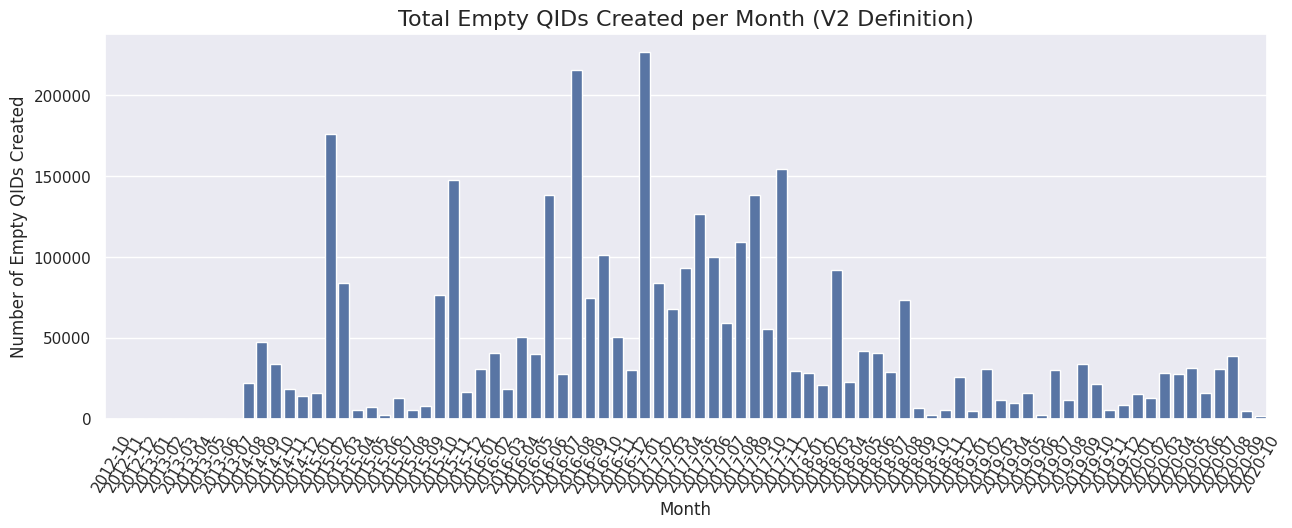

In [178]:
ax = sns.barplot(
    data=df_empty_qids_per_month_v2,
    x="event_year_month",
    y="total_empty_qid_creations",
)
ax.set_title(
    "Total Empty QIDs Created per Month (V2 Definition)",
    size=16,
)
ax.set(xlabel="Month", ylabel="Number of Empty QIDs Created")
ax.tick_params(axis="x", rotation=60)
plt.savefig(get_plot_axis_png_title(ax=ax, directory="visual_outputs"), bbox_inches="tight")
plt.show()

##### V3 Population Definition

In [104]:
empty_qids_per_month_v3_query = """
SELECT
    event_year_month AS event_year_month,
    count(event_year_month) AS total_empty_qid_creations

FROM
    df_created_empty_qids_v3

GROUP BY
    event_year_month

ORDER BY
    event_year_month ASC
"""

In [105]:
df_empty_qids_per_month_v3 = spark.sql(empty_qids_per_month_v3_query).toPandas()

In [106]:
display_peek(df_empty_qids_per_month_v3)


Display of DataFrame cleared.



In [107]:
# We don't have data for some months as there were no created empty items made during them.

In [108]:
max(df_empty_qids_per_month_v3["event_year_month"])

'2024-03'

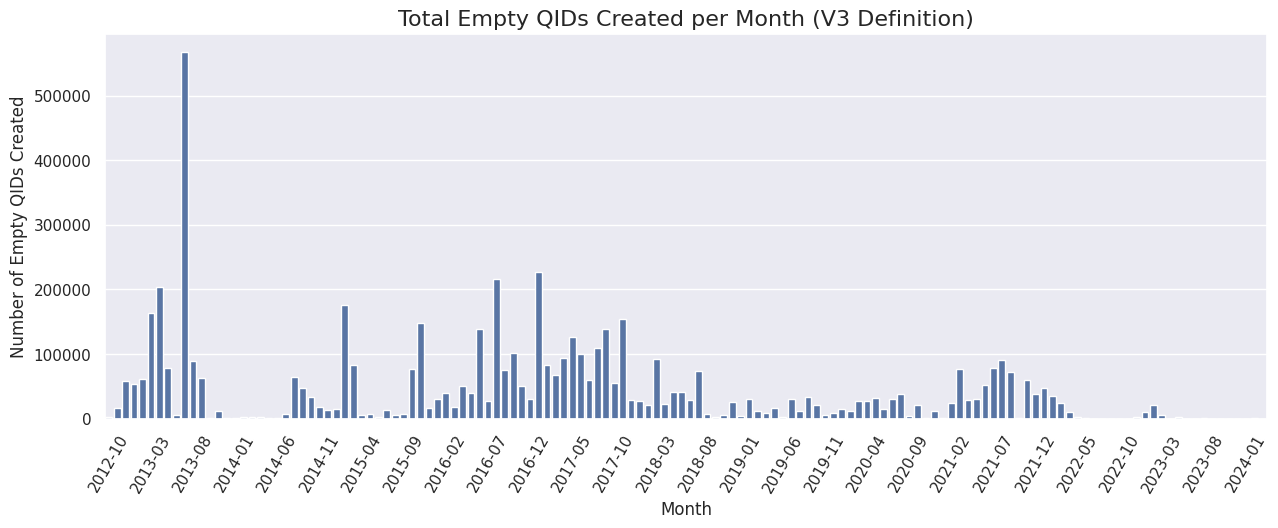

In [109]:
ax = sns.barplot(
    data=df_empty_qids_per_month_v3,
    x="event_year_month",
    y="total_empty_qid_creations",
)
ax.set_title(
    "Total Empty QIDs Created per Month (V3 Definition)",
    size=16,
)
ax.set(xlabel="Month", ylabel="Number of Empty QIDs Created")
for ind, label in enumerate(ax.get_xticklabels()):
    if ind % 5 == 0:
        label.set_visible(True)
    else:
        label.set_visible(False)
ax.tick_params(axis="x", rotation=60)
plt.savefig(get_plot_axis_png_title(ax=ax, directory="visual_outputs"), bbox_inches="tight")
plt.show()

In [110]:
df_empty_qids_per_month_v3_2023_2024 = df_empty_qids_per_month_v3[
    df_empty_qids_per_month_v3["event_year_month"] >= "2023-01"
]

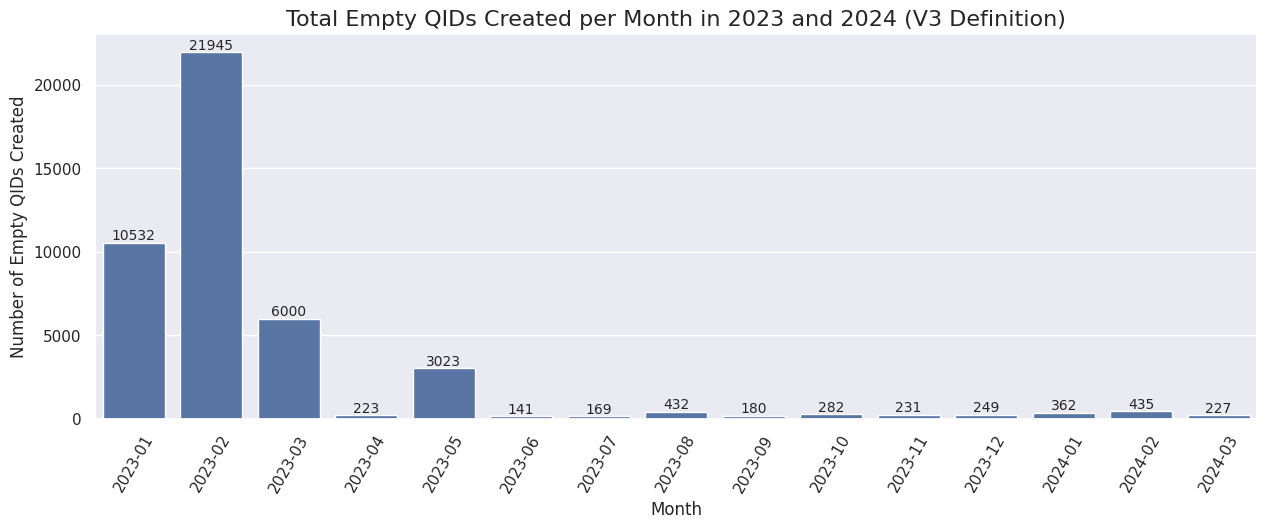

In [111]:
ax = sns.barplot(
    data=df_empty_qids_per_month_v3_2023_2024,
    x="event_year_month",
    y="total_empty_qid_creations",
)
ax.set_title(
    "Total Empty QIDs Created per Month in 2023 and 2024 (V3 Definition)",
    size=16,
)
ax.set(xlabel="Month", ylabel="Number of Empty QIDs Created")
ax.bar_label(ax.containers[0], fontsize=10)
ax.tick_params(axis="x", rotation=60)
plt.savefig(get_plot_axis_png_title(ax=ax, directory="visual_outputs"), bbox_inches="tight")
plt.show()

There's a dramatic drop off in 2023 and 2024. I also checked how this looks for max revision byte cutoffs of 180 and 190, and there really wasn't a significant change.

### Population B

**Description**

Items in population A that were created empty (results of Task 1.1).

#### Task 2: Number Currently Deleted

##### V2 Population Definition.

In [121]:
deleted_created_empty_qids_v2_query = f"""
SELECT DISTINCT
    page_title AS deleted_created_empty_qid

FROM
    wmf.mediawiki_history

WHERE
    wiki_db = 'wikidatawiki'
    AND page_namespace_is_content = True
    AND snapshot = '{snapshot_to_query}'
    AND event_entity = 'revision'
    AND event_type = 'create'
    AND page_revision_count = 1
    -- Factor in bytes allocated to a first revision given the size of a QID.
    AND revision_text_bytes = CASE
        WHEN LENGTH(page_title) = 2 THEN 152
        WHEN LENGTH(page_title) = 3 THEN 153
        WHEN LENGTH(page_title) = 4 THEN 154
        WHEN LENGTH(page_title) = 5 THEN 155
        WHEN LENGTH(page_title) = 6 THEN 156
        WHEN LENGTH(page_title) = 7 THEN 157
        WHEN LENGTH(page_title) = 8 THEN 158
        WHEN LENGTH(page_title) = 9 THEN 159
        WHEN LENGTH(page_title) = 10 THEN 160
    END
    AND page_is_deleted = True
"""

In [123]:
df_deleted_created_empty_qids_v2 = spark.sql(
    deleted_created_empty_qids_v2_query
).cache()
df_deleted_created_empty_qids_v2.createOrReplaceTempView(
    "df_deleted_created_empty_qids_v2"
)

In [124]:
total_deleted_created_empty_qids_v2_query = """
SELECT
    count(DISTINCT deleted_created_empty_qid) AS total_deleted_created_empty_qids

FROM
    df_deleted_created_empty_qids_v2
"""

In [125]:
df_total_deleted_created_empty_qids_v2 = spark.sql(
    total_deleted_created_empty_qids_v2_query
)

In [126]:
df_total_deleted_created_empty_qids_v2.show()

+--------------------------------+
|total_deleted_created_empty_qids|
+--------------------------------+
|                           33739|
+--------------------------------+



In [174]:
percent_created_empty_currently_deleted_v2 = round(33739 / 3540260 * 100, 2)
percent_created_empty_currently_deleted_v2

0.95

##### V3 Population Definition

In [74]:
deleted_created_empty_qids_v3_query = f"""
SELECT DISTINCT
    page_title AS deleted_created_empty_qid

FROM
    wmf.mediawiki_history

WHERE
    wiki_db = 'wikidatawiki'
    AND page_namespace_is_content = True
    AND snapshot = '{snapshot_to_query}'
    AND event_entity = 'revision'
    AND event_type = 'create'
    AND page_revision_count = 1
    -- Factor in bytes that are within a range small enough to be an empty first edit.
    AND 148 < revision_text_bytes
    AND revision_text_bytes < 170
    AND page_is_deleted = True
"""

In [76]:
df_deleted_created_empty_qids_v3 = spark.sql(
    deleted_created_empty_qids_v3_query
).cache()
df_deleted_created_empty_qids_v3.createOrReplaceTempView(
    "df_deleted_created_empty_qids_v3"
)

In [77]:
total_deleted_created_empty_qids_v3_query = """
SELECT
    count(DISTINCT deleted_created_empty_qid) AS total_deleted_created_empty_qids

FROM
    df_deleted_created_empty_qids_v3
"""

In [79]:
df_total_deleted_created_empty_qids_v3 = spark.sql(
    total_deleted_created_empty_qids_v3_query
)

In [80]:
df_total_deleted_created_empty_qids_v3.show()

+--------------------------------+
|total_deleted_created_empty_qids|
+--------------------------------+
|                           44385|
+--------------------------------+



In [81]:
percent_created_empty_currently_deleted_v3 = round(44385 / 5075471 * 100, 2)
percent_created_empty_currently_deleted_v3

0.87

### Population C

**Description**

Items in population B that are currently not deleted (results of Task 1.1 that are the complement of the results of Task 2). We'll be using the V3 definition of the population for this.

In [116]:
not_deleted_created_empty_qids_v3_query = f"""
SELECT DISTINCT
    page_title AS not_deleted_created_empty_qid

FROM
    wmf.mediawiki_history

WHERE
    wiki_db = 'wikidatawiki'
    AND page_namespace_is_content = True
    AND snapshot = '{snapshot_to_query}'
    AND event_entity = 'revision'
    AND event_type = 'create'
    AND page_revision_count = 1
    -- Factor in bytes that are within a range small enough to be an empty first edit.
    AND 148 < revision_text_bytes
    AND revision_text_bytes < 170
    AND page_is_deleted = False
"""

In [117]:
df_not_deleted_created_empty_qids_v3 = spark.sql(
    not_deleted_created_empty_qids_v3_query
).cache()
df_not_deleted_created_empty_qids_v3.createOrReplaceTempView(
    "df_not_deleted_created_empty_qids_v3"
)

In [118]:
not_deleted_created_empty_qids_v3_edits_query = f"""
SELECT
    h.page_title AS not_deleted_created_empty_qid,
    count(h.revision_id) AS number_of_revisions

FROM
    wmf.mediawiki_history AS h

JOIN
    df_not_deleted_created_empty_qids_v3 AS e

ON
    h.page_title = e.not_deleted_created_empty_qid

WHERE
    h.wiki_db = 'wikidatawiki'
    AND h.page_namespace_is_content = True
    AND h.snapshot = '{snapshot_to_query}'
    AND h.event_entity = 'revision'
    AND h.event_type = 'create'

GROUP BY
    h.page_title
"""

In [119]:
df_not_deleted_created_empty_qids_v3_edits = spark.sql(
    not_deleted_created_empty_qids_v3_edits_query
).cache()
df_not_deleted_created_empty_qids_v3_edits.createOrReplaceTempView(
    "df_not_deleted_created_empty_qids_v3_edits"
)

#### Task 3.1: No Further Edits

In [120]:
one_edit_not_deleted_created_empty_qids_v3_query = """
SELECT
    count(not_deleted_created_empty_qid) AS total_one_edit_not_deleted_created_empty_qids_v3

FROM
    df_not_deleted_created_empty_qids_v3_edits

WHERE
    number_of_revisions = 1
"""

In [121]:
df_one_edit_not_deleted_created_empty_qids_v3 = spark.sql(
    one_edit_not_deleted_created_empty_qids_v3_query
)

In [122]:
df_one_edit_not_deleted_created_empty_qids_v3.show()

+------------------------------------------------+
|total_one_edit_not_deleted_created_empty_qids_v3|
+------------------------------------------------+
|                                               0|
+------------------------------------------------+



#### Task 3.2: At Least One Further Edit

In [123]:
more_edits_not_deleted_created_empty_qids_v3_query = """
SELECT
    count(not_deleted_created_empty_qid) AS total_more_edits_not_deleted_created_empty_qids_v3

FROM
    df_not_deleted_created_empty_qids_v3_edits

WHERE
    number_of_revisions > 1
"""

In [124]:
df_more_edits_not_deleted_created_empty_qids_v3 = spark.sql(
    more_edits_not_deleted_created_empty_qids_v3_query
)

In [125]:
df_more_edits_not_deleted_created_empty_qids_v3.show()

+--------------------------------------------------+
|total_more_edits_not_deleted_created_empty_qids_v3|
+--------------------------------------------------+
|                                           5031086|
+--------------------------------------------------+



#### Task 3.3: Graphs of Edit Amounts

In [126]:
edit_counts_not_deleted_created_empty_qids_v3_query = """
SELECT
    number_of_revisions AS number_of_revisions,
    count(number_of_revisions) AS total_not_deleted_qids

FROM
    df_not_deleted_created_empty_qids_v3_edits

GROUP BY
    number_of_revisions

ORDER BY
    number_of_revisions ASC
"""

In [127]:
df_edit_counts_not_deleted_created_empty_qids_v3 = spark.sql(
    edit_counts_not_deleted_created_empty_qids_v3_query
).toPandas()

In [132]:
display_peek(df_edit_counts_not_deleted_created_empty_qids_v3)


Display of DataFrame cleared.



In [134]:
df_edit_counts_not_deleted_created_empty_qids_v3_max_100 = (
    df_edit_counts_not_deleted_created_empty_qids_v3[
        df_edit_counts_not_deleted_created_empty_qids_v3["number_of_revisions"] <= 100
    ]
)

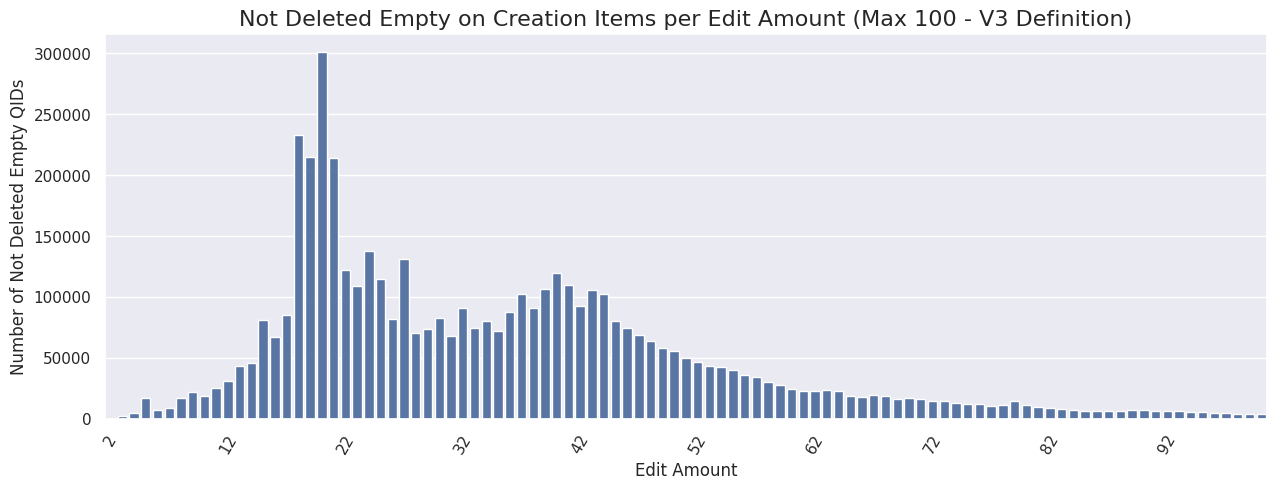

In [135]:
ax = sns.barplot(
    data=df_edit_counts_not_deleted_created_empty_qids_v3_max_100,
    x="number_of_revisions",
    y="total_not_deleted_qids",
)
ax.set_title(
    "Not Deleted Empty on Creation Items per Edit Amount (Max 100 - V3 Definition)",
    size=16,
)
ax.set(xlabel="Edit Amount", ylabel="Number of Not Deleted Empty QIDs")
for ind, label in enumerate(ax.get_xticklabels()):
    if ind % 10 == 0:
        label.set_visible(True)
    else:
        label.set_visible(False)
ax.tick_params(axis="x", rotation=60)
plt.savefig(get_plot_axis_png_title(ax=ax, directory="visual_outputs"), bbox_inches="tight")
plt.show()

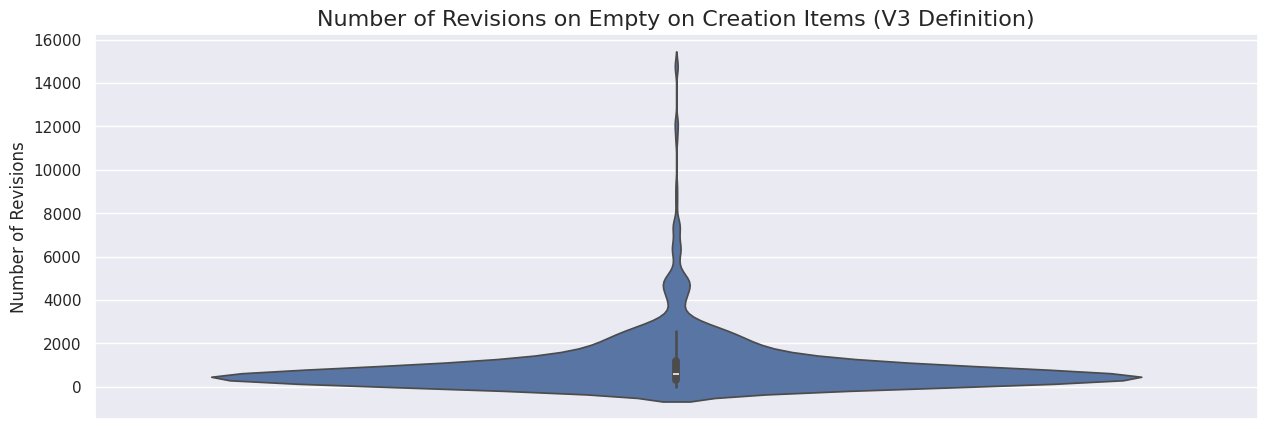

In [138]:
ax = sns.violinplot(
    y=df_edit_counts_not_deleted_created_empty_qids_v3["number_of_revisions"]
)
ax.set_title(
    "Number of Revisions on Empty on Creation Items (V3 Definition)",
    size=16,
)
ax.set(ylabel="Number of Revisions")
plt.savefig(get_plot_axis_png_title(ax=ax, directory="visual_outputs"), bbox_inches="tight")
plt.show()